In [1]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 13.3/13.3 MB 92.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
pjme = pd.read_csv("PJME_hourly.csv", index_col = [0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


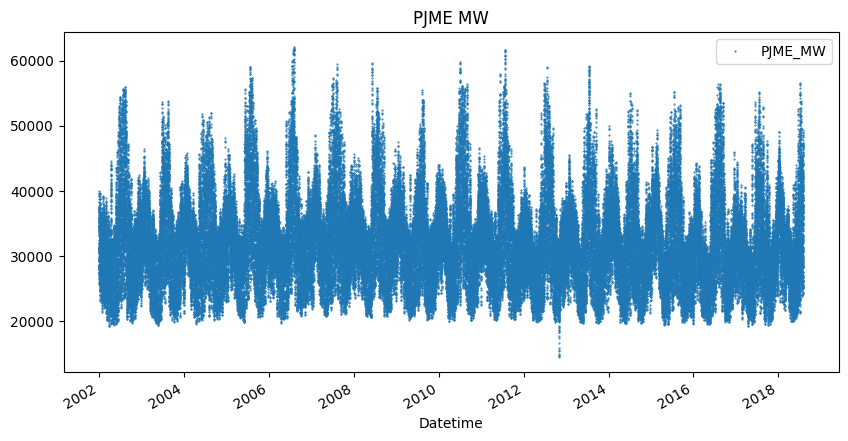

In [6]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10,5),
          ms=1,
          color=color_pal[0],
          title='PJME MW' )
plt.show()

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories = ['Monday', 'Tuesday', 
                                          'Wednesday', 'Thursday', 
                                          'Friday', 'Saturday', 'Sunday'],
                            ordered = True)

In [12]:
def create_features(df, label):
    df = df. copy()
    df ['date' ]=df.index
    df['hour' ]=df['date' ].dt.hour
    df ['dayofweek' ]=df ['date' ].dt.dayofweek
    df['weekday' ]=df['date' ].dt.day_name()
    df['weekday' ]=df['weekday' ].astype(cat_type)
    df ['quarter' ]=df['date' ].dt. quarter
    df['month' ]=df['date' ].dt.month
    df['year' ]=df ['date'].dt.year
    df ['dayofyear' ]=df['date'].dt.dayofyear
    df['dayofmonth' ]=df ['date' ].dt.day
    #df['weekofyear' ]=df ['date'].dt.weekofyear
    df['weekofyear'] = df['date'].dt.strftime('%U').astype(int)
    df['date_offset' ]=(df.date.dt.month*100 + df.date.dt.day-320)*1300
    df['season' ]=pd.cut(df['date_offset'], [0,300, 602, 900, 1300],
                         labels=['Spring','Summer','Fall','Winter' ])
    
    return df

In [17]:
create_features(pjme, 'PJME MW')

,PJME_MW,date,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
Datetime,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,Tuesday,4,12,2002,365,31,52,1184300,NaN
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,Tuesday,4,12,2002,365,31,52,1184300,NaN
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,Tuesday,4,12,2002,365,31,52,1184300,NaN
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,Tuesday,4,12,2002,365,31,52,1184300,NaN
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,Tuesday,4,12,2002,365,31,52,1184300,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,Monday,1,1,2018,1,1,0,-284700,NaN
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,Monday,1,1,2018,1,1,0,-284700,NaN
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,Monday,1,1,2018,1,1,0,-284700,NaN


In [ ]:
X, y = create_features(pjme, 'PJME_MW')

In [ ]:
features_and_target = pd.concat([X,y], axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x = 'weekday',
            y = 'PJME_MW',
            hue='season',
            ax=ax,
            linewidth = 1)

ax.set_title('Power consumption')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

In [19]:
# train test split by date

split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

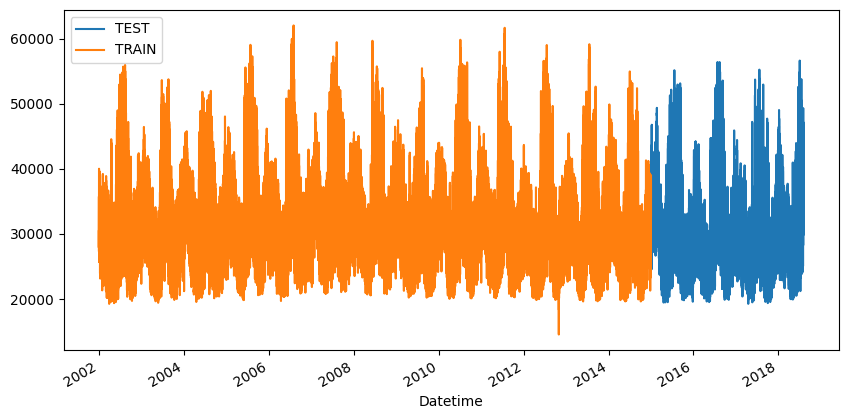

In [21]:
pjme_test.rename(columns = {'PJME_MW':'TEST'}).join(pjme_train.rename(columns={'PJME_MW':'TRAIN'}), how='outer').plot(figsize=(10,5))
plt.show()

In [30]:
# To change the column name to 'ds' and 'y' respectively for prophet()
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds',
                                                              'PJME_MW':'y'})

In [31]:
# Model training
model=Prophet()
model.fit(pjme_train_prophet)

10:23:59 - cmdstanpy - INFO - Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# To change the column name to 'ds' and 'y' respectively for prophet()
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds',
                                                            'PJME_MW':'y'})

# Prediction
pjme_test_fcst = model.predict(pjme_test_prophet)

In [ ]:
pjme_test_fcst.head()

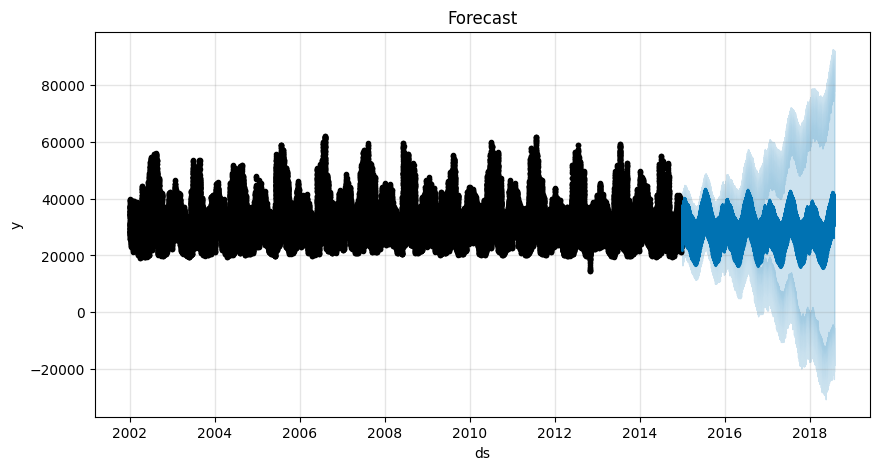

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Forecast')
plt.show()

In [36]:
pjme_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31200.339206,23685.031594,32747.023725,31200.339206,31200.339206,-2842.562168,-2842.562168,-2842.562168,-4430.590454,...,1281.474328,1281.474328,1281.474328,306.553958,306.553958,306.553958,0.0,0.0,0.0,28357.777038
1,2015-01-01 02:00:00,31200.300721,22298.323196,31764.800526,31200.300721,31200.300721,-4347.079710,-4347.079710,-4347.079710,-5927.617356,...,1272.694228,1272.694228,1272.694228,307.843418,307.843418,307.843418,0.0,0.0,0.0,26853.221011
2,2015-01-01 03:00:00,31200.262235,21237.453079,30373.777970,31200.262235,31200.262235,-5218.803832,-5218.803832,-5218.803832,-6790.687108,...,1262.708907,1262.708907,1262.708907,309.174370,309.174370,309.174370,0.0,0.0,0.0,25981.458403
3,2015-01-01 04:00:00,31200.223749,21268.392424,30350.667007,31200.223749,31200.223749,-5360.281813,-5360.281813,-5360.281813,-6922.470785,...,1251.642133,1251.642133,1251.642133,310.546839,310.546839,310.546839,0.0,0.0,0.0,25839.941936
4,2015-01-01 05:00:00,31200.185263,21741.232855,30979.405430,31200.185263,31200.185263,-4685.843322,-4685.843322,-4685.843322,-6237.434051,...,1239.629878,1239.629878,1239.629878,311.960851,311.960851,311.960851,0.0,0.0,0.0,26514.341942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31434,2018-08-02 20:00:00,29990.541853,-7166.074722,90665.515678,-18817.991602,79380.217035,11270.642587,11270.642587,11270.642587,4451.194608,...,1033.740842,1033.740842,1033.740842,5785.707138,5785.707138,5785.707138,0.0,0.0,0.0,41261.184440
31435,2018-08-02 21:00:00,29990.503367,-8040.426604,89305.377408,-18818.693217,79385.233151,10497.898356,10497.898356,10497.898356,3696.013328,...,1021.126579,1021.126579,1021.126579,5780.758449,5780.758449,5780.758449,0.0,0.0,0.0,40488.401724
31436,2018-08-02 22:00:00,29990.464882,-9327.904983,87043.071636,-18819.394832,79390.249266,8868.711490,8868.711490,8868.711490,2084.548252,...,1008.355019,1008.355019,1008.355019,5775.808219,5775.808219,5775.808219,0.0,0.0,0.0,38859.176372
31437,2018-08-02 23:00:00,29990.426396,-12545.768110,85000.951616,-18820.096448,79395.265381,6660.923530,6660.923530,6660.923530,-105.164938,...,995.231932,995.231932,995.231932,5770.856536,5770.856536,5770.856536,0.0,0.0,0.0,36651.349926


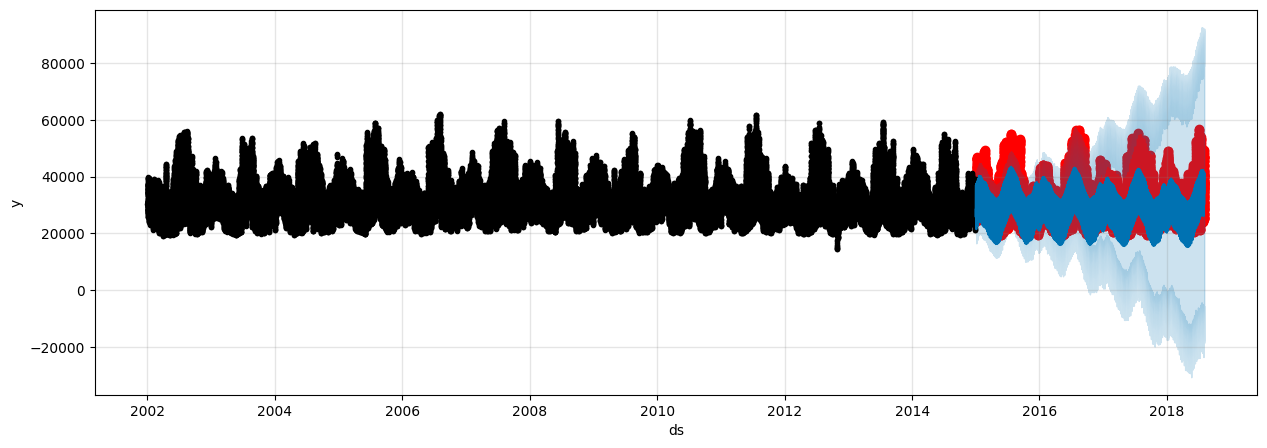

In [35]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [40]:
# to get the MAE score
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat'])

5183.308123570645

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np. array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [42]:
# To get MAE score in percentage
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat'])

16.505469633679194

### some error here so will check again

ConversionError: Failed to convert value(s) to axis units: '2015-01-01'

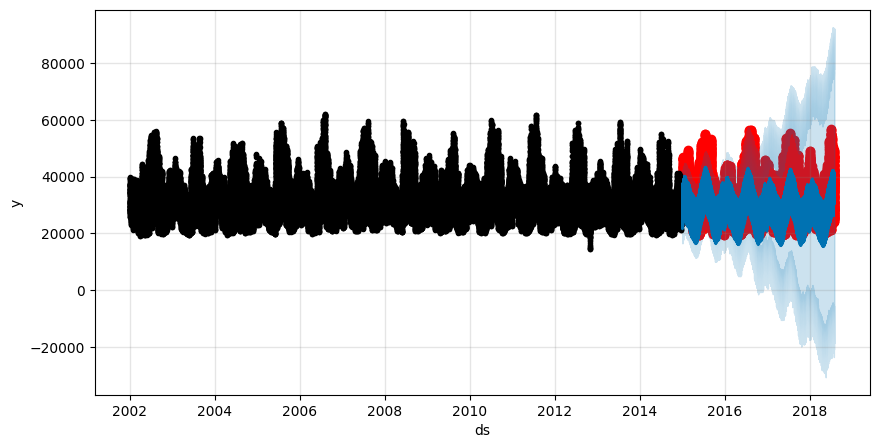

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color = 'r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower= '2015-01-01', # January
              upper='2015-02-01') # February
ax.set_ylim(0,6000)
plot.plt.subtitle('Forecast vs Actual')

### up is will be check again

In [50]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name = True)
holiday_df = pd. DataFrame(data = holidays, columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns= {'holiday':'holiday', 
                                                       'index':'ds'})

In [51]:
holiday_model = Prophet(holidays = holiday_df)
holiday_model.fit(pjme_train_prophet)

11:27:45 - cmdstanpy - INFO - Chain [1] start processing
11:29:58 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
pjme_test_fcst = holiday_model.predict(pjme_test_prophet)

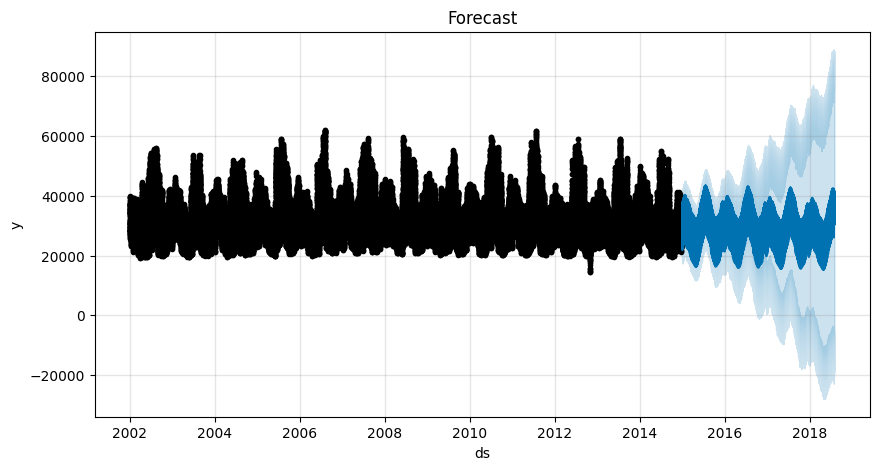

In [53]:
# To plot the model forecast
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Forecast')
plt.show()

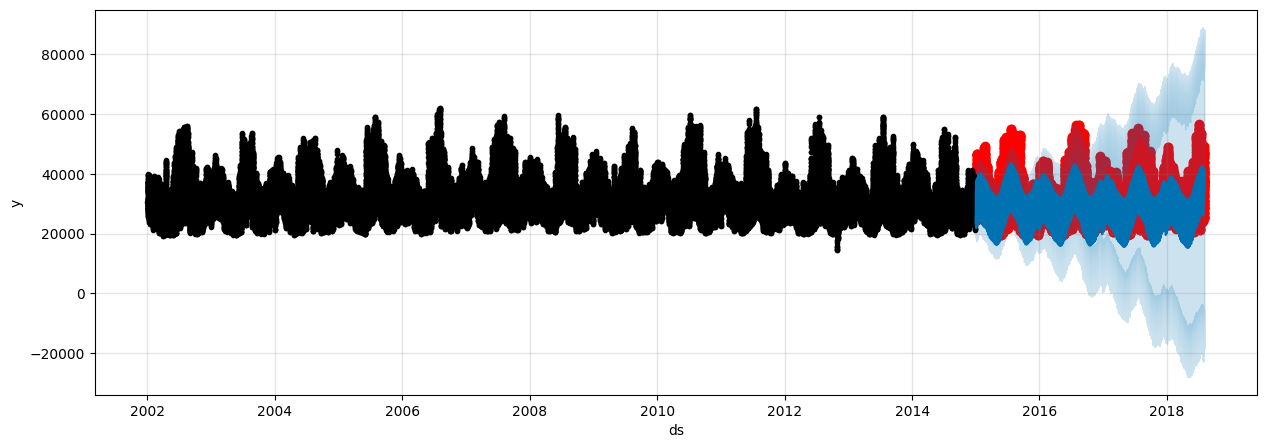

In [54]:
# To plot the model forecast with actual
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW' ], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [56]:
#To create a future timeline and predict future as forecast
future = holiday_model.make_future_dataframe(periods=365*24,
                                             freq='h', include_history = False)

forecast = holiday_model.predict(future)
forecast[['ds','yhat']]

,ds,yhat
0,2015-01-01 01:00:00,25537.447405
1,2015-01-01 02:00:00,24035.495631
2,2015-01-01 03:00:00,23165.961037
3,2015-01-01 04:00:00,23026.348547
4,2015-01-01 05:00:00,23702.320333
...,...,...
8755,2015-12-31 20:00:00,37091.988355
8756,2015-12-31 21:00:00,36322.233122
8757,2015-12-31 22:00:00,34696.085627
8758,2015-12-31 23:00:00,32491.348335
